In [6]:
#!git clone https://github.com/whyhardt/SPICE.git

In [7]:
# !pip install -e SPICE

In [1]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

from spice.estimator import SpiceEstimator
from spice.resources.spice_utils import SpiceConfig
from spice.utils.convert_dataset import convert_dataset
from spice.resources.rnn import BaseRNN
from spice.utils.plotting import plot_session

# For custom RNN
import torch
import torch.nn as nn

## Load dataset

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [2]:
# Load your data
dataset = convert_dataset(
    file = '../data/ganesh2024a/ganesh2024a.csv',
    df_participant_id='subjID',
    df_choice='chose_high',
    df_reward='reward',
    df_block='blocks',
    additional_inputs=['contrast_difference'],
    timeshift_additional_inputs=True,
    )

# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)

# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = len(dataset.xs[..., -1].unique())

print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
n_actions = dataset.ys.shape[-1]
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([1176, 24, 8])
Number of participants: 98
Number of actions in dataset: 2
Number of additional inputs: 1


## SPICE Setup

Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

In [3]:
spice_config = SpiceConfig(
    library_setup={
        'value_reward_chosen': ['contr_diff', 'reward'],
        'value_reward_not_chosen': ['contr_diff'],
        'value_choice': ['contr_diff', 'choice'],
    },
    
    memory_state={
            'value_reward': 0.,
            'value_choice': 0.,
        }
)

And now we are going to define the SPICE model which is a child of the `BaseRNN` and `torch.nn.Module` class and takes as required arguments:
1. `spice_config (SpiceConfig)`: previously defined SpiceConfig object
2. `n_actions (int)`: number of possible actions in your dataset (including non-displayed ones if applicable).
3. `n_participants (int)`: number of participants in your dataset.

As usual for a `torch.nn.Module` we have to define at least the `__init__` method and the `forward` method.
The `forward` method gets called when computing a forward pass through the model and takes as inputs `(inputs (SpiceDataset.xs), prev_state (dict, default: None), batch_first (bool, default: False))` and returns `(logits (torch.Tensor, shape: (n_participants*n_blocks*n_experiments, timesteps, n_actions)), updated_state (dict))`. Two necessary method calls inside the forward pass are:
1. `self.init_forward_pass(inputs, prev_state, batch_first) -> SpiceSignals`: returns a `SpiceSignals` object which carries all relevant information already processed.
2. `self.post_forward_pass(SpiceSignals, batch_first) -> SpiceSignals`: does some re-arranging of the logits to adhere to `batch_first`.

In [4]:
class SPICERNN(BaseRNN):
    
    def __init__(self, spice_config, **kwargs):
        super().__init__(spice_config=spice_config, **kwargs)
        
        # participant embedding
        self.participant_embedding = self.setup_embedding(num_embeddings=self.n_participants, embedding_size=self.embedding_size, dropout=0.)
        
        # set up the submodules
        self.setup_module(key_module='value_reward_chosen', input_size=2+self.embedding_size)
        self.setup_module(key_module='value_reward_not_chosen', input_size=1+self.embedding_size)
        self.setup_module(key_module='value_choice', input_size=2+self.embedding_size)
        
    def forward(self, inputs, prev_state, batch_first=False):
        
        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)
        
        contr_diffs = spice_signals.additional_inputs.repeat(1, 1, self.n_actions)
        rewards_chosen = (spice_signals.actions * spice_signals.rewards).sum(dim=-1, keepdim=True).repeat(1, 1, self.n_actions)
        
        # time-invariant participant features
        participant_embeddings = self.participant_embedding(spice_signals.participant_ids)
        
        for timestep in spice_signals.timesteps:
            
            # update chosen value
            self.call_module(
                key_module='value_reward_chosen',
                key_state='value_reward',
                action_mask=spice_signals.actions[timestep],
                inputs=(contr_diffs[timestep], rewards_chosen[timestep]),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # update not chosen value
            self.call_module(
                key_module='value_reward_not_chosen',
                key_state='value_reward',
                action_mask=1-spice_signals.actions[timestep],
                inputs=(contr_diffs[timestep]),  # add input rewards_chosen[timestep] for counterfactual updating (adjust in config as well)
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # same for choice values
            self.call_module(
                key_module='value_choice',
                key_state='value_choice',
                action_mask=spice_signals.actions[timestep],
                inputs=(contr_diffs[timestep], spice_signals.actions[timestep]),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            spice_signals.logits[timestep] = self.state['value_reward'] + self.state['value_choice']
            
        spice_signals = self.post_forward_pass(spice_signals, batch_first)
        
        return spice_signals.logits, self.get_state()

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [5]:
path_spice = '../params/ganesh2024a/spice_ganesh2024a.pkl'

estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=SPICERNN,
        spice_config=spice_config,
        n_actions=2,
        n_participants=n_participants,
        
        # rnn training parameters
        epochs=1000,
        warmup_steps=200,
        learning_rate=0.01,
        
        # sindy fitting parameters
        sindy_weight=0.1,
        sindy_threshold=0.05,
        sindy_threshold_frequency=1,
        sindy_threshold_terms=1,
        sindy_cutoff_patience=100,
        sindy_epochs=1000,
        sindy_alpha=0.0001,
        sindy_library_polynomial_degree=2,
        sindy_ensemble_size=1,
        
        # additional generalization parameters
        batch_size=1024,
        bagging=True,
        scheduler=True,
        
        verbose=True,
        save_path_spice=path_spice,
    )

In [ ]:
print(f"\nStarting training on {estimator.device}...")
print("=" * 80)
estimator.fit(dataset.xs, dataset.ys, dataset.xs, dataset.ys)
# estimator.load_spice(args.model)
print("=" * 80)
print("\nTraining complete!")

# Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training on cpu...

Training the RNN...
Epoch 1/1000 --- L(Train): 0.6989506 --- L(Val, RNN): 0.6408207 --- L(Val, SINDy): 0.7097650 --- Time: 0.43s; --- Convergence: 6.80e-01; LR: 1.00e-02; Metric: inf; Bad epochs: 0/100
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 26):
value_reward_chosen[t+1] = -0.006 1 + 0.999 value_reward_chosen[t] + -0.002 contr_diff + -0.003 reward + -0.0 value_reward_chosen^2 + 0.002 value_reward_chosen*contr_diff + -0.001 value_reward_chosen*reward + -0.001 contr_diff^2 + -0.001 contr_diff*reward + -0.002 reward^2 
value_reward_not_chosen[t+1] = 0.006 1 + 0.998 value_reward_not_chosen[t] + -0.007 contr_diff + -0.0 value_reward_not_chosen^2 + -0.0 value_reward_not_chosen*contr_diff + 0.002 contr_diff^2 
value_choice[t+1] = -0.008 1 + 0.996 value_choice[t] + 0.006 contr_diff + -0.008 choice + 0.003 value_choice^2 + -0.002 value_choice*contr_diff + -0.003 value_choice*choice + -0.003 contr_d

In [6]:
estimator.load_spice(path_spice)

## GRU for benchmarking

In [7]:
import sys

sys.path.append('../..')
from weinhardt2025.benchmarking.benchmarking_gru import GRU, training, setup_agent_gru

In [ ]:
epochs = 1000

gru = GRU(n_actions=n_actions, additional_inputs=1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

gru = training(
    gru=gru,
    optimizer=optimizer,
    dataset_train=dataset,
    dataset_test=dataset,
    epochs=epochs,
    )


Epoch 1/1000: L(Train): 0.6775030493736267; L(Test): 0.5822796821594238
Epoch 2/1000: L(Train): 0.5848801732063293; L(Test): 0.5116956830024719
Epoch 3/1000: L(Train): 0.5086604356765747; L(Test): 0.46075400710105896
Epoch 4/1000: L(Train): 0.46378234028816223; L(Test): 0.4428197145462036
Epoch 5/1000: L(Train): 0.4437780976295471; L(Test): 0.4543968141078949
Epoch 6/1000: L(Train): 0.4604732096195221; L(Test): 0.4685104191303253
Epoch 7/1000: L(Train): 0.4695923328399658; L(Test): 0.4697604775428772
Epoch 8/1000: L(Train): 0.47187739610671997; L(Test): 0.45993420481681824
Epoch 9/1000: L(Train): 0.45509061217308044; L(Test): 0.4462375044822693
Epoch 10/1000: L(Train): 0.45772090554237366; L(Test): 0.43464934825897217
Epoch 11/1000: L(Train): 0.4478502571582794; L(Test): 0.42908936738967896
Epoch 12/1000: L(Train): 0.42654502391815186; L(Test): 0.4298192262649536
Epoch 13/1000: L(Train): 0.4358992874622345; L(Test): 0.4333026111125946
Epoch 14/1000: L(Train): 0.4346815049648285; L(Test

In [8]:
path_gru = '../../weinhardt2025/params/ganesh2024a/gru_ganesh2024a.pkl'
# torch.save(gru.state_dict(), path_gru)
gru_agent = setup_agent_gru(path_gru)

## Plot SPICE against benchmark models

value_reward_chosen[t+1] = -0.933 1 + 0.008 value_reward_chosen[t] + 0.07 contr_diff + 1.015 reward + 0.0 reward^2 
value_reward_not_chosen[t+1] = -0.234 1 + 1.0 value_reward_not_chosen[t] 
value_choice[t+1] = 1.0 value_choice[t] 


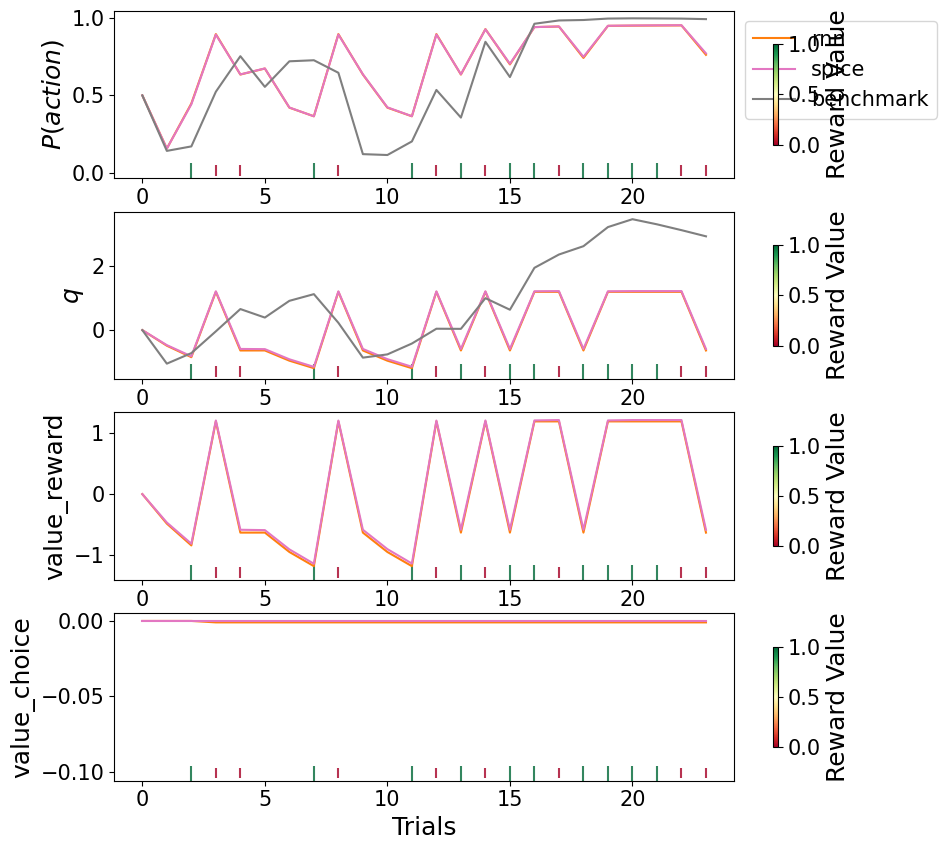

In [ ]:
# plotting
participant_id = 7

estimator.print_spice_model(participant_id)

agents = {
    # add baseline agent here
    'rnn': estimator.rnn_agent,
    'spice': estimator.spice_agent,
    'benchmark': gru_agent,
}

fig, axs = plot_session(agents, dataset.xs[participant_id])
plt.show()